In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import pandas as pd
from MDAnalysis.analysis import distances
from scipy.linalg import expm
import os
from IPython.display import clear_output

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import pandas as pd
from MDAnalysis.analysis import distances
from scipy.linalg import expm
import os

### sequence and structural network module

def network(df,entry):
    pdb_id = df.PDB_ID[entry]
    os.system('cp data/PDB_files/pdb'+pdb_id+'.ent protein_temp_.pdb')

    Receptor_chain = df.Receptor_chain[entry]
    peptide_chain_ID = df.peptide_chain_ID[entry]

    # import a pdb file as the universe
    PDB = 'protein_temp_.pdb'
    u = mda.Universe(PDB,PDB)

    # select only groups of receptor chain if receptor is longer than 50 aa
    # otherwise select the whole protein
    #if len(df['Receptor sequence'][entry]) > 50:
        #CA = u.select_atoms('protein and name CA and chainID '+str(Receptor_chain))
    #else:
        #CA = u.select_atoms('protein and name CA and not chainID '+str(peptide_chain_ID))
    CA = u.select_atoms('protein and name CA and chainID '+str(Receptor_chain))
    CA.write("CA.pdb")

    # create the amino acid sequence list
    seq = CA.atoms.resnames

    # list of atom index with alternate locations (altLoc)
    alt_index = []
    for i in range(len(CA)):
        if CA[i].altLoc != '' and CA[i].altLoc != 'A':
            alt_index.append(i)

    # positions of all c-alpha atoms - dropping altLoc - trim data to match the FASTA
    pos_CA = np.delete(CA.positions,alt_index,axis=0)
    n_amino = df.iloc[entry,:].len_protein_seq
    pos_CA = pos_CA[:n_amino]
    sequence = np.delete(seq,alt_index)
    sequence = sequence[:n_amino]

    # distance matrix
    dist_mat = distances.distance_array(pos_CA, 
                                        pos_CA, 
                                        box=u.dimensions)

    # adjacency matrix
    cutoff = 7  # cutoff distance 
    A = dist_mat - cutoff; A[A>0] = 0; A[A<0] = 1

    # communicability matrix (G) 
    # and (relative) subgraph centrality (SC)
    G = expm(A); SC = G.diagonal()/np.min(G.diagonal())

    return A, G, SC, sequence

def binding_data(df,entry,A,G,SC):
    # get binding residues
    bind_res_str = df.bind_res_renum[entry].split()
    bind_res_index = [int(r[1:])-1 for r in bind_res_str]
    bind_res_index = [res for res in bind_res_index if res < len(A)]
    bind_res_num = len(bind_res_index)
    return bind_res_index, bind_res_num

# amino acids were grouped by physico-chemical properties (PCP)
# group 1 (R): aromatic side-chains (Phe, Trp, Tyr)
# group 2 (L): aliphatic side-chains (Ile, Val, Leu, Ala, Gly, Pro, Met)
# group 3 (P): basic (positively-charged) side-chains (Lys, Arg, His)
# group 4 (N): acidic (negatively-charged) side-chains (Asp, Glu)
# group 5 (U): polar-uncharged sideshains (Ser, Cys, Thr, Asn, Gln)
# SEE BELOW - **initialize**

# identifying interaction types from a pair of tripeptide
# output 7 components
# first 3 components: direct contacts
# last 4 components: contacting with neighboring residues (indirect)
# one-hot encode 25 PCP dipeptide interaction types
# then output to 7x25 array

def dipep(tripep1,tripep2):
    dipep_index = []
    
    # direct contact
    dipep_index.append(dipeptide_name.index(tripep1[0]+tripep2[0]))
    dipep_index.append(dipeptide_name.index(tripep1[1]+tripep2[1]))
    dipep_index.append(dipeptide_name.index(tripep1[2]+tripep2[2]))
    
    # indirect contact
    dipep_index.append(dipeptide_name.index(tripep1[0]+tripep2[1]))
    dipep_index.append(dipeptide_name.index(tripep1[1]+tripep2[2]))
    dipep_index.append(dipeptide_name.index(tripep1[2]+tripep2[1]))
    dipep_index.append(dipeptide_name.index(tripep1[1]+tripep2[0]))
    
    # one-hot encoding
    dipep_one_hot = np.zeros((7,25))
    dipep_one_hot[np.arange(7),np.array(dipep_index)] = 1

    return dipep_one_hot
    
# 7x25x125x125 4D arrays: all possible interactions (dipeptide) types between 
# all 125 tripeptide types scored from an amino acid residue of protein 
# with all 125 tripeptide types scored from a peptide chain
# first 3 layers: direct contacts
# last 4 layers: contacting with neighboring residues (indirect)

# create lists of dipeptide and tripeptide PCP characteristics

def initialize_dipeptide_tripeptide():
    dipeptide_name = []
    for amino1 in ['R','L','P','N','U']:
        for amino2 in ['R','L','P','N','U']:
            dipeptide_name.append(amino1+amino2)

    tripeptide_name = []
    for amino1 in ['R','L','P','N','U']:
        for amino2 in ['R','L','P','N','U']:
            for amino3 in ['R','L','P','N','U']:
                tripeptide_name.append(amino1+amino2+amino3)
    
    header200 = []
    for order in ['_o1','_o2','_o3','_o4']:
        for contact in ['_d','_i']:
            for dipeptide in dipeptide_name:
                header200.append(dipeptide+order+contact)

    return dipeptide_name, tripeptide_name, header200

def initialize_interactions():
    pcp_interactions = np.zeros((7,25,125,125))
    for i in range(125):
        for j in range(125):
            pcp_interactions[:,:,i,j] = dipep(tripeptide_name[i],tripeptide_name[j])

    return pcp_interactions

# convert amino acids into physico-chemical properties (PCP)            
            
def pcp_convert(amino):
    if amino in ['PHE', 'TRP', 'TYR', 'F', 'W', 'Y']:
        pcp = 'R'
    elif amino in ['ILE','VAL','LEU','ALA','GLY','PRO','MET','I','V','L','A','G','P','M']:
        pcp = 'L'
    elif amino in ['LYS', 'ARG', 'HIS', 'K', 'R', 'H']:
        pcp = 'P'
    elif amino in ['ASP', 'GLU', 'D', 'E']:
        pcp = 'N'
    elif amino in ['SER', 'CYS', 'THR', 'ASN', 'GLN', 'S', 'C', 'T', 'N', 'Q']:
        pcp = 'U'
    else:
        pcp = 'L'
    return pcp
            
# create tripeptide vectors of size 125:
# 111, 112, ..., 121, 122, ..., 211, 212, ..., 555
# add +1 onto one-hot feature vector of matched tripeptide

def tripeptide_convert(a1,a2,a3):
    tripeptide_vec = np.zeros(125)
    tripeptide = pcp_convert(a1) + pcp_convert(a2) + pcp_convert(a3)
    tripeptide_vec[ tripeptide_name.index(tripeptide) ] += 1
    return tripeptide_vec
    
# primary tripeptide featurizer for protein
def protein_tripep_feats(res_index, A, sequence):

    # searching for non-clustering neighbor tripep residues XYZ 
    # consider Y that (adjacency) A(X,Y)=1 and A(Y,Z)=1 and A(X,Z)=0 
    index_Y = res_index
    index_X_Z = np.where(A[index_Y]==1)[0]  # A(X,Y)=1 and A(Y,Z)=1
    A_X_Z = A[index_X_Z][:,index_X_Z]  # submatrix of A at X and Z

    index_X = index_X_Z[ np.where(A_X_Z==0)[0] ]  # getting the satisfied X
    index_Z = index_X_Z[ np.where(A_X_Z==0)[1] ]  # getting the satisfied Z
    
    # FEATURE 1-125: tripeptide counts 
    # getting tripeptide sequence and convert into a 125-element vector
    tripep_feat_vec = np.zeros(125)
    for i in range(len(index_X)):
        tripep_feat_vec += tripeptide_convert(sequence[ index_X[i] ],
                                       sequence[ index_Y ],
                                       sequence[ index_Z[i] ])  
    # weight the frequency of finding each type of tripeptide by probability    
    tripep_feat_vec = tripep_feat_vec / (2*len(index_X)+1)
    return tripep_feat_vec

# primary tripeptide featurizer for protein
def peptide_tripep_feats(df, entry):
    # peptide length
    peptide_seq = df.peptide_seq.iloc[entry]
    peptide_length = df.len_peptide_seq.iloc[entry]

    # searching for neighbor tripeptide residues XYZ
    # for 1st, 2nd, 3rd, and 4th-order nearest neighbors
    tripep_index = [[],[],[],[]]
    for res_index in range(peptide_length):
        for order in range(1,5):
            index_X = res_index - order
            index_Y = res_index
            index_Z = res_index + order
            if index_Z < peptide_length and index_X >= 0:
                tripep_index[order-1].append([index_X,index_Y,index_Z])
    
    # FEATURE 1-125: tripeptide counts 
    # getting tripeptide sequence and convert into a 125-element vector
    tripep_feat_vec = np.zeros((4,125))
    for order_1 in range(4):
        for i_tripep in tripep_index[order_1]:
            tripep_feat_vec[order_1] += tripeptide_convert(peptide_seq[ i_tripep[0] ],
                                           peptide_seq[ i_tripep[1] ],
                                           peptide_seq[ i_tripep[2] ])  
    # weight the frequency of finding each type of tripeptide by peptide length    
    tripep_feat_vec = tripep_feat_vec / peptide_length
    return tripep_feat_vec    
            
# extracting 50 interaction features 
# 25 dipeptide PCP characteristics with direct contacts
# 25 dipeptide PCP characteristics with indirect contacts

def dipep_feature50(pep125,prot125):
    # outer products: row:protein, col:peptide >> possible tripeptide pairs
    prot125_pep125 = np.outer(pep125,prot125)

    # stacking the 2D array into a 4D array for broadcasting with pcp_interactions
    prot125_pep125_4d = []
    for i in range(7):
        prot125_pep125_3d = []
        for j in range(25):
            prot125_pep125_3d.append(prot125_pep125)
        prot125_pep125_4d.append(prot125_pep125_3d)
    prot125_pep125_4d = np.array(prot125_pep125_4d)

    # broadcast into dipeptide feature vector
    prot125_pep125_pcp =  prot125_pep125_4d*pcp_interactions
    dipep_sum = np.sum(np.sum(prot125_pep125_pcp,axis=3),axis=2)
    dipep_direct = np.sum(dipep_sum[:3,:],axis=0) # with direct contacts
    dipep_indirect = 0.5*np.sum(dipep_sum[3:,:],axis=0) # with direct contacts
    return dipep_direct, dipep_indirect

# extract 200 feature for protein's amino acid - peptide interactions
# 1-50: 1st nearest neighbor peptide residues 
## 1-25,26-50 direct and indirect contacts 
# 51-50: 2nd nearest neighbor peptide residues 
## 50+ 1-25,26-50 direct and indirect contacts 
# 101-150: 3rd nearest neighbor peptide residues 
## 100+ 1-25,26-50 direct and indirect contacts 
# 151-200: 4th nearest neighbor peptide residues 
## 125+ 1-25,26-50 direct and indirect contacts 

def featurizer200(df,entry,res_index):
    feat_vec = np.zeros(200)
    for order_1 in range(4): 
        prot125 = protein_tripep_feats(res_index,A,sequence)
        pep125 = peptide_tripep_feats(df,entry)[order_1]
        dipep_direct, dipep_indirect = dipep_feature50(pep125,prot125)
        feat_vec[50*order_1:50*order_1+25] = dipep_direct
        feat_vec[50*order_1+25:50*order_1+50] = dipep_direct
    return feat_vec

### sequence and structural network module

def network_from_PDB(PDB):
    u = mda.Universe(PDB,PDB)

    # select only groups of receptor chain if receptor is longer than 50 aa
    # otherwise select the whole protein
    #if len(df['Receptor sequence'][entry]) > 50:
        #CA = u.select_atoms('protein and name CA and chainID '+str(Receptor_chain))
    #else:
        #CA = u.select_atoms('protein and name CA and not chainID '+str(peptide_chain_ID))
    CA = u.select_atoms('protein and name CA')
    CA.write("CA.pdb")

    # create the amino acid sequence list
    seq = CA.atoms.resnames

    # list of atom index with alternate locations (altLoc)
    alt_index = []
    for i in range(len(CA)):
        if CA[i].altLoc != '' and CA[i].altLoc != 'A':
            alt_index.append(i)

    # positions of all c-alpha atoms - dropping altLoc - trim data to match the FASTA
    pos_CA = np.delete(CA.positions,alt_index,axis=0)
    n_amino = len(seq)
    pos_CA = pos_CA[:n_amino]
    sequence = np.delete(seq,alt_index)
    sequence = sequence[:n_amino]

    # distance matrix
    dist_mat = distances.distance_array(pos_CA, 
                                        pos_CA, 
                                        box=u.dimensions)

    # adjacency matrix
    cutoff = 7  # cutoff distance 
    A = dist_mat - cutoff; A[A>0] = 0; A[A<0] = 1

    # communicability matrix (G) 
    # and (relative) subgraph centrality (SC)
    G = expm(A); SC = G.diagonal()/np.min(G.diagonal())

    return A, G, SC, sequence

### network with varied cutoff

def network_from_PDB_cutoff(PDB,cutoff):
    u = mda.Universe(PDB,PDB)

    # select only groups of receptor chain if receptor is longer than 50 aa
    # otherwise select the whole protein
    #if len(df['Receptor sequence'][entry]) > 50:
        #CA = u.select_atoms('protein and name CA and chainID '+str(Receptor_chain))
    #else:
        #CA = u.select_atoms('protein and name CA and not chainID '+str(peptide_chain_ID))
    CA = u.select_atoms('protein and name CA')
    CA.write("CA.pdb")

    # create the amino acid sequence list
    seq = CA.atoms.resnames

    # list of atom index with alternate locations (altLoc)
    alt_index = []
    for i in range(len(CA)):
        if CA[i].altLoc != '' and CA[i].altLoc != 'A':
            alt_index.append(i)

    # positions of all c-alpha atoms - dropping altLoc - trim data to match the FASTA
    pos_CA = np.delete(CA.positions,alt_index,axis=0)
    n_amino = len(seq)
    pos_CA = pos_CA[:n_amino]
    sequence = np.delete(seq,alt_index)
    sequence = sequence[:n_amino]

    # distance matrix
    dist_mat = distances.distance_array(pos_CA, 
                                        pos_CA, 
                                        box=u.dimensions)

    # adjacency matrix
    A = dist_mat - cutoff; A[A>0] = 0; A[A<0] = 1

    # communicability matrix (G) 
    # and (relative) subgraph centrality (SC)
    G = expm(A); SC = G.diagonal()/np.min(G.diagonal())

    return A, G, SC

In [4]:
# loading the pre-trained model

## some time later...

import pickle

# load the model from disk
filename = 'model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [5]:
# create empty dataframe for inputting data
pep_data_input = pd.DataFrame()

# list of peptide sequences
# Ex. synthetic peptide to bind with ACE2 RBD from 
# https://www.frontiersin.org/journals/microbiology/articles/10.3389/fmicb.2022.910343/full

peptide_seq_list = []
len_peptide_seq_list = []

f = open('pep_input','r')
for line in f:
    if line[:-1] != '':
        peptide_seq_list.append(line.split()[0])
        len_peptide_seq_list.append(len(line.split()[0]))
f.close()

# add data into the dataframe
pep_data_input['entry'] = list(range(len(peptide_seq_list)))
pep_data_input['peptide_seq'] = peptide_seq_list
pep_data_input['len_peptide_seq'] = len_peptide_seq_list

In [6]:
pep_data_input

,entry,peptide_seq,len_peptide_seq
0,0,EEQAKTFLDKFNHEAEDLFYQSSLASWNYN,30


In [85]:
# OR upload the dataset

# load the peptide data and screen for only peptides with lengths <30

pep_data = pd.read_csv('general_amps.csv')
pep_data = pep_data[["Name","Source","Sequence","Sequence_Length"]]
pep_data = pep_data[pep_data.Sequence_Length<=30]

# screen for only peptides with complete sequence information

n_pep = len(pep_data)

Sequence_Complete = np.ones(n_pep).astype('int')
len_peptide_seq_list = np.zeros(n_pep).astype('int')
for i in range(n_pep):
    seq = pep_data.Sequence.iloc[i]
    for amino in str(seq):
        len_peptide_seq_list[i] = len(str(seq))
        if amino not in 'RHKDESTNQCUGPAVILMFYW':
            Sequence_Complete[i] = 0
            break
pep_data['Sequence_Length'] = len_peptide_seq_list
            
pep_data['Sequence_Complete'] = Sequence_Complete
pep_data = pep_data[pep_data.Sequence_Complete==1]

pep_data['entry'] = list(range(len(pep_data)))
pep_data = pep_data.rename(columns={'Sequence':'peptide_seq','Sequence_Length':'len_peptide_seq'})

pep_data_input = pep_data

In [86]:
pep_data_input

,Name,Source,peptide_seq,len_peptide_seq,Sequence_Complete,entry
0,Epicidin 280 (Bacteriocin),Staphylococcus epidermidis BN 280 (Gram-positi...,SLGPAIKATRQVCPKATRFVTVSCKKSDCQ,30,1,0
1,Microbisporicin A1 (Bacteriocin),Microbispora corallina (Gram-positive bacteria),VTSWSLCTPGCTSPGGGSNCSFCC,24,1,1
2,Ruminococcin A (RumA; Bacteriocin),Ruminococcus gnavus & Ruminococcus hansenii (G...,GNGVLKTISHECNMNTWQFLFTCC,24,1,2
3,Lantibiotic michiganin-A (Bacteriocin),Clavibacter michiganensis subsp. Michiganensis...,SSSGWLCTLTIECGTIICACR,21,1,3
14,Plantaricin J (PlnJ; Bacteriocin),Lactobacillus plantarum C11 (Gram-positive bac...,GAWKNFWSSLRKGFYDGEAGRAIRR,25,1,4
...,...,...,...,...,...,...
6005,P8,Synthetic construct,SALEEQLKTFLDKFMHELEDLLYQLAL,27,1,3354
6006,P9,Synthetic construct,SALEEQYKTFLDKFMHELEDLLYQLSL,27,1,3355
6007,P10,Synthetic construct,SALEEQYKTFLDKFMHELEDLLYQLAL,27,1,3356
6008,FBP,Synthetic construct,RGAHIKGRWKSRCHRF,16,1,3357


In [13]:
protein_file = 'rbd_new.pdb'

from IPython.display import clear_output

# extract 200 dipeptide interaction features for each peptide data
n_peptide = len(pep_data_input)

# initialization
dipeptide_name, tripeptide_name, header200 = initialize_dipeptide_tripeptide()
pcp_interactions = initialize_interactions()

# create network data and tripeptide features
A, G, SC, sequence = network_from_PDB(protein_file)

n_data = len(pep_data_input)*len(A)
X_input = np.zeros((n_data,200))

index = 0
for entry in list(pep_data_input.entry):
    n_amino = len(A)
    for res_index in range(n_amino):
        X_input[index+res_index] = featurizer200(pep_data_input,entry,res_index)
    index += n_amino
    clear_output(wait=True)
    print(str(entry)+'/'+str(n_peptide))

X_pep_data_input = X_input   

0/1


In [16]:
import matplotlib.pyplot as plt

### Plotting epitope features

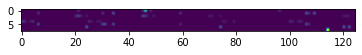

In [27]:
res_index_binding = [77,161,165,106,112,144,5,100]
prot125_epitope = np.zeros((8,125))
for i in range(8):
    prot125_epitope[i] = protein_tripep_feats(res_index_binding[i], A, sequence)
plt.imshow(prot125_epitope)

In [40]:
print(340+np.array([77,161,165,106,112,144,5,100]))

[417 501 505 446 452 484 345 440]


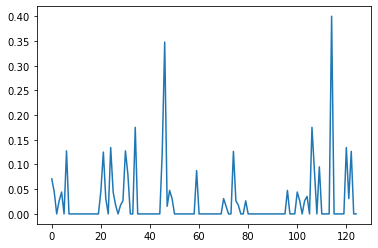

UPU
LUL
LLU
ULL
UUR
RUU
LLR
RLL
PUU
UUP
RUL
LUR
ULU
PLU
ULP
LLL
RRR
NUL
LUN
RUR


In [33]:
sum_prot125_epitope = np.sum(prot125_epitope,axis=0)
prot125_epitope_sorted = np.argsort(sum_prot125_epitope)[::-1]
plt.plot(sum_prot125_epitope)
plt.show()
for i in range(20):
    print(tripeptide_name[prot125_epitope_sorted[i]])

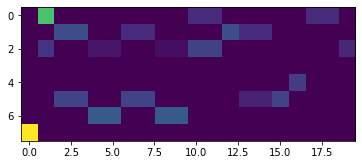

In [39]:
prot125_epitope_top20 = np.zeros((8,20))
for i in range(8):
    prot125_epitope_top20[i] = prot125_epitope[i,prot125_epitope_sorted[:20]]
plt.imshow(prot125_epitope_top20)
plt.show()
np.savetxt('prot125_epitope_top20.csv',prot125_epitope_top20,delimiter=',')

In [37]:
prot125_epitope[0,prot125_epitope_sorted[:20]]

array([0.        , 0.28571429, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04761905, 0.04761905, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04761905, 0.04761905, 0.        ])

### Plotting predicted residue features

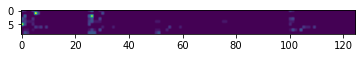

In [41]:
res_index_binding = [29,33,34,35,83,154,155,7,149]
prot125_predicted = np.zeros((9,125))
for i in range(9):
    prot125_predicted[i] = protein_tripep_feats(res_index_binding[i], A, sequence)
plt.imshow(prot125_predicted)

In [42]:
print(340+np.array([29,33,34,35,83,154,155,7,149]))

[369 373 374 375 423 494 495 347 489]


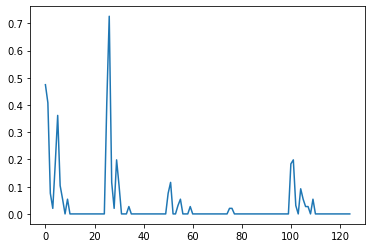

LRL
RRR
LRR
RRL
RLR
LRU
URL
RRU
URR
PRL
LRP
RLL
LLR
URU
PRR
RRP
PLR
ULR
ULU
RLP


In [43]:
sum_prot125_predicted = np.sum(prot125_predicted,axis=0)
prot125_predicted_sorted = np.argsort(sum_prot125_predicted)[::-1]
plt.plot(sum_prot125_predicted)
plt.show()
for i in range(20):
    print(tripeptide_name[prot125_predicted_sorted[i]])

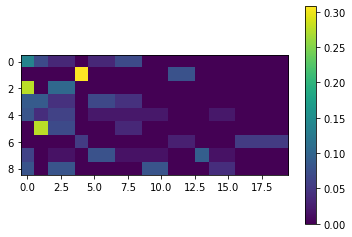

In [83]:
prot125_predicted_top20 = np.zeros((9,20))
for i in range(9):
    prot125_predicted_top20[i] = prot125_predicted[i,prot125_predicted_sorted[:20]]
plt.imshow(prot125_predicted_top20)
plt.colorbar()
plt.show()
np.savetxt('prot125_predicted_top20.csv',prot125_predicted_top20,delimiter=',')

### Plotting peptide features

In [45]:
# primary tripeptide featurizer for protein
def peptide_tripep(peptide_seq):
    # peptide length
    peptide_length = len(peptide_seq)

    # searching for neighbor tripeptide residues XYZ
    # for 1st, 2nd, 3rd, and 4th-order nearest neighbors
    tripep_index = [[],[],[],[]]
    for res_index in range(peptide_length):
        for order in range(1,5):
            index_X = res_index - order
            index_Y = res_index
            index_Z = res_index + order
            if index_Z < peptide_length and index_X >= 0:
                tripep_index[order-1].append([index_X,index_Y,index_Z])
    
    # FEATURE 1-125: tripeptide counts 
    # getting tripeptide sequence and convert into a 125-element vector
    tripep_feat_vec = np.zeros((4,125))
    for order_1 in range(4):
        for i_tripep in tripep_index[order_1]:
            tripep_feat_vec[order_1] += tripeptide_convert(peptide_seq[ i_tripep[0] ],
                                           peptide_seq[ i_tripep[1] ],
                                           peptide_seq[ i_tripep[2] ])  
    # weight the frequency of finding each type of tripeptide by peptide length    
    tripep_feat_vec = tripep_feat_vec / peptide_length
    return tripep_feat_vec    


In [104]:
peptide_list = ['EEQAKTFLDKFNHEAEDLFYQSSLASWNYN','ALWKDILKNAGKAALNEINQIVQ','ALWKDILKNLLKAALNEINQIVQ','ALWKDILKNAGKAALNEINQLVNQ','AVDLAKIANIANKVLSSLFGK','GLLSSLSSVA','TPFKISIHL','ASILTNAS','ITVCISVC','ISVCITVC','PHSCN']
peptide_feats_list = []
for peptide_seq in peptide_list:
    peptide_feats_list.append( peptide_tripep(peptide_seq).flatten() )
peptide_vec_array = np.array(peptide_feats_list)
peptide_vec_avg = np.average(peptide_vec_array,axis=0)
peptide_feat_argsort = np.argsort(peptide_vec_avg)[::-1]

In [105]:
print('#### feat NAME ####')
for i in range(20):
    feat_index = peptide_feat_argsort[i]
    feat_name_index = feat_index % 125
    print(tripeptide_name[feat_name_index])
print('#### feat ORDER ####')
for i in range(20):
    feat_index = peptide_feat_argsort[i]
    feat_order_index = (feat_index // 125)+1
    print(feat_order_index)

#### feat NAME ####
LUL
ULU
LUL
LLL
LLL
LLL
LLU
ULU
ULL
LUU
UUL
UUU
LPL
LUU
PLL
LPU
LUL
LUU
LLU
LLP
#### feat ORDER ####
1
1
2
4
2
3
1
2
1
1
1
2
2
2
3
1
3
3
2
1


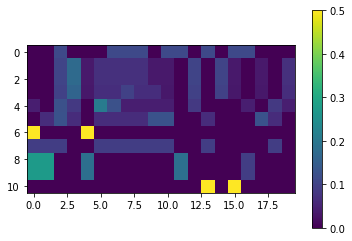

In [106]:
pep125_predicted_top20 = np.zeros((11,20))
for i in range(11):
    pep125_predicted_top20[i] = peptide_vec_array[i,peptide_feat_argsort[:20]]

# normalization
sum_row = np.sum(pep125_predicted_top20,axis=1)
scale = np.transpose(np.meshgrid(sum_row,np.zeros(20))[0])
pep125_predicted_top20_scaled = pep125_predicted_top20/scale

# plotting
plt.imshow(pep125_predicted_top20_scaled)
plt.colorbar()
plt.show()
np.savetxt('pep125_predicted_top20.csv',pep125_predicted_top20_scaled,delimiter=',')

### Seeking for neighbor residues

In [25]:
np.where(A[res_index_binding[3]]==1)[0]

array([104, 105, 106, 107, 157])

### Feature Importances

In [8]:
#***** feature importance and sequence score ******
# binding score prototype: SUM(feature200 importance dot feature200 vector) over all residues
# **** NEXT VERSION: also accounting clustering of positive binding residue ****

importances = loaded_model.feature_importances_

importances_scores = np.zeros(len(pep_data_input))
index = 0
for i in range(len(pep_data_input)):
    n_amino = len(A)
    importances_array = np.array([importances[:200] for j in range(n_amino)])
    importances_scores[i] = np.sum(X_pep_data_input[index:index+n_amino]*importances_array)
    index += n_amino

pep_data_input["importances_scores"] = importances_scores

# plot score data 
plt.plot(importances_scores,'.')
plt.show()
#ref_score = 10.0000
#print('percentile')
#print(len(pep_data[pep_data.importances_scores<ref_score])/len(pep_data)*100.0)

n_data = len(X_pep_data_input)

# network feature extraction
res_index_list = []
SC_array = np.zeros(n_data)
deg_array = np.zeros(n_data)
commu_array = np.zeros(n_data)
A, G, SC, sequence = network_from_PDB(protein_file)

index = 0
for entry in list(pep_data_input.entry):
    n_amino = len(A)
    SC_array[index:index+n_amino] = SC
    deg_array[index:index+n_amino] = np.sum(A,axis=1)
    commu_array[index:index+n_amino] = np.sum(G,axis=1)
    index += n_amino
    clear_output(wait=True)
    print(str(entry)+'/'+str(len(pep_data_input)))

# create and concat a featurized dataframe from the numpy array
data_X_pep_input = pd.DataFrame(X_pep_data_input)

# add network features
data_X_pep_input["SC"] = SC_array
data_X_pep_input["deg"] = np.log(deg_array)
data_X_pep_input["commu"] = np.log(commu_array)

# run the trained ML model
y_pred_pep = loaded_model.predict(data_X_pep_input)   

# run the trained ML model - predict prob
y_pred_pep_proba = loaded_model.predict_proba(data_X_pep_input)    

0/1


/Users/thana/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/thana/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


/var/folders/03/ww9pl1zx1y162xj16ph_rcch0000gn/T/ipykernel_21412/225140227.py:39: RuntimeWarning: invalid value encountered in true_divide
  pep_data_input['(n_edges-n_triangles)/bind_res_num'] = (np.array(n_edges) - np.array(n_triangles))/np.array(pep_data_input.bind_res_num_pred)
/var/folders/03/ww9pl1zx1y162xj16ph_rcch0000gn/T/ipykernel_21412/225140227.py:40: RuntimeWarning: invalid value encountered in true_divide
  pep_data_input['(n_edges-n_triangles)/n_edges'] = (np.array(n_edges) - np.array(n_triangles))/np.array(n_edges)


0/1


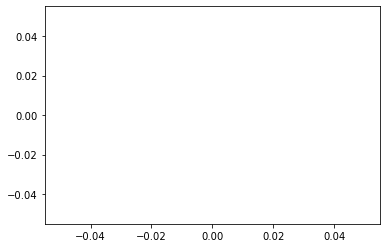

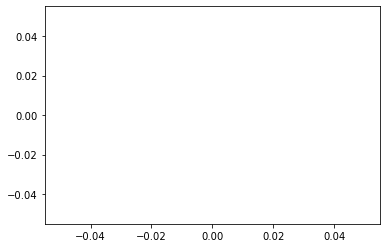

In [9]:
import networkx as nx

# predicted binding site and find total number of edges / triangles
bind_res_index_pred = []
bind_res_num_pred = []
n_edges = []
n_triangles = []
n_largest_cc = []
index = 0

# specified only 1 protein
A, G, SC, sequence = network_from_PDB(protein_file)

# network with 10 Angs cutoff
A10, G10, SC10 = network_from_PDB_cutoff(protein_file,10)

for i in range(len(pep_data_input)):
    entry = pep_data_input.entry.iloc[i]
    n_amino = len(A10)
    bind_res_index_ = np.where(np.array(y_pred_pep[index:index+n_amino]))[0]
    bind_res_index_pred.append(list(bind_res_index_))
    bind_res_num_pred.append(len(bind_res_index_))
    subarray = A10[bind_res_index_][:,bind_res_index_]
    n_edges.append(int(0.5*np.sum(subarray)))
    n_triangles.append(int(sum(nx.triangles(nx.from_numpy_matrix(subarray)).values())/3))
    if subarray.shape==(0,0):
        subarray = np.zeros((1,1))
    max_clust_size = int(max(np.sum(np.nan_to_num(np.ceil(expm(subarray))/np.ceil(expm(subarray))),axis=1)))
    n_largest_cc.append(max_clust_size)
    index += n_amino
    clear_output(wait=True)
    print(str(entry)+'/'+str(len(pep_data_input)))
pep_data_input['bind_res_index_pred'] = bind_res_index_pred
pep_data_input['bind_res_num_pred'] = bind_res_num_pred
pep_data_input['n_edges'] = n_edges
pep_data_input['n_largest_cc'] = n_largest_cc
pep_data_input['n_triangles'] = n_triangles 
pep_data_input['n_edges-n_triangles'] = np.array(n_edges) - np.array(n_triangles)                 
pep_data_input['(n_edges-n_triangles)/bind_res_num'] = (np.array(n_edges) - np.array(n_triangles))/np.array(pep_data_input.bind_res_num_pred)
pep_data_input['(n_edges-n_triangles)/n_edges'] = (np.array(n_edges) - np.array(n_triangles))/np.array(n_edges)

pep_data_positive = pep_data_input.dropna()
plt.plot(pep_data_positive['n_edges-n_triangles'],pep_data_positive['importances_scores'],'.')
plt.show()
plt.plot(pep_data_positive['n_largest_cc'],pep_data_positive['importances_scores'],'.')
plt.show()

In [10]:
pep_data_positive.sort_values('bind_res_num_pred',ascending=False).to_csv('rbd_screened.csv')
pep_data_positive.sort_values('bind_res_num_pred',ascending=False)

,entry,peptide_seq,len_peptide_seq,importances_scores,bind_res_index_pred,bind_res_num_pred,n_edges,n_largest_cc,n_triangles,n_edges-n_triangles,(n_edges-n_triangles)/bind_res_num,(n_edges-n_triangles)/n_edges


0.07130100792201761


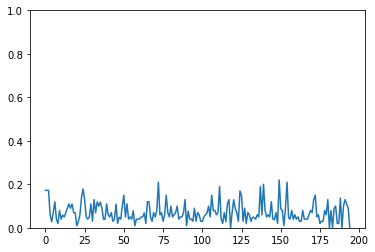

In [11]:
entry = 0
n_amino = len(A)
plt.ylim(0,1)
plt.plot(y_pred_pep_proba[entry*n_amino:(entry+1)*n_amino,1])
print(sum(y_pred_pep_proba[entry*n_amino:(entry+1)*n_amino,1])/n_amino)
plt.show()

0.0


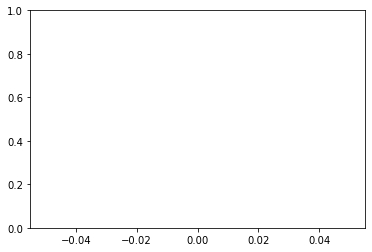

In [12]:
entry = 1
n_amino = len(A)
plt.ylim(0,1)
plt.plot(y_pred_pep_proba[entry*n_amino:(entry+1)*n_amino,1])
print(sum(y_pred_pep_proba[entry*n_amino:(entry+1)*n_amino,1])/n_amino)
plt.show()

In [99]:
deg = np.sum(A,axis=1)
commu = np.sum(G,axis=1)

In [101]:
np.argsort(commu)[::-1]

array([ 60, 170,  59, 168, 167, 169,  61,  57, 166, 171, 172,  58,  13,
        10,  62,   8,   9,  56,  95, 173,  14,  15,  64,  94,  55,  93,
        92,  63, 165,  96, 174,  98,  11,  12,   7,  97,  16,  54,  17,
        91, 164, 113, 112,  99,  82, 156,  90,  39,  37, 175,  18,  38,
        36,  79, 163,  81, 114,  66,  80,  40, 102, 103,  35,  65,  53,
        52, 157, 162,  78, 115,  83, 151,  67,  84, 104, 152, 183, 158,
       160, 153,  69, 150,  89,  34,  41, 108, 161,  19, 111, 107,  77,
       155, 101, 100, 176, 154,  85,  76,  20, 121, 105,  42, 127, 128,
       109,  68, 133,   6, 182, 132, 148,  75, 124, 184, 123,  86,  70,
       116, 149, 147, 126,  74,  71, 120,  21, 117, 110, 159,  72, 122,
       177, 106,  43,  23, 125, 134,  87,  88,  22, 143,   4,  51,  44,
         5, 130, 179, 146, 144,  33, 185, 135,  73, 131, 129,  24, 119,
        25,  32, 178, 145, 142,  46,  27,  47,  29,  49, 180,  26,  31,
        28, 136, 186,  45,  30, 181,  48,   3, 140,  50, 118,   

In [102]:
np.argsort(deg)[::-1]

array([166, 167,  79,  60,   9, 165, 168,  56, 170, 172, 157,  57,  81,
        10,  59,  80, 183,  95,  64,  54,  84, 150,  58, 156, 147,  61,
        11, 132, 133,  55,  63, 112,   8, 174, 103,  39,  92,  69,  13,
       173, 171, 169,  89,  90,  91, 115, 114, 113,  82,  93,  94,  96,
       104,  85, 148, 164,  62,  52,  53,  99,  12,  98,  14,   7, 184,
       182, 108,  17, 175, 107,  15, 121,  40,  83, 158, 153, 151,  23,
        78,  38,  36,  35,  37,  71,  41,  27,  47,  86,  67,  65,  25,
        72,  66,  97,   4, 143, 124, 123, 152, 185, 155, 160,  16, 163,
        29,  18, 109,  22, 134, 102, 146,  42,  43,  68,  44,  30, 144,
       149, 161, 162, 176, 179,  26,  49, 154,  74,  46,  21,  31, 117,
        20,  24,  87,  19, 105, 122, 125,  28, 127, 128,  77,  76,  34,
       111,   3, 177,  32, 100,  48,  51, 116, 120, 126,  75, 130,  70,
       135, 136, 101, 142, 140,   5,   6,   2,   1,   0,  33, 186, 178,
       159, 145,  45, 138, 190, 131, 129, 119, 110, 106, 192,  8

In [103]:
np.argsort(SC)[::-1]

array([ 60, 167, 166, 170,  57, 168, 172,  59,  56, 171, 169,  58,  61,
        13,  10,  64,   9, 173,   8,  55, 165,  95,  63,  62, 174,  92,
        54,  79,  93,  80,  15,  94,  14, 164,  96,  81,  98, 157,  11,
       156,  91,  17,  12,  82, 103, 113,  16,  97, 104,  99, 112,  84,
        78,  83,   7, 183,  39, 175,  90, 163,  52, 114,  53, 148, 150,
        18, 132,  40, 147, 158, 108, 107, 133,  65, 115,  69,  38, 151,
        37,  66, 102, 162,  36, 152,  77,  89,  67,  85,  76, 153, 160,
        41, 155, 105, 121,  35, 134, 184, 161, 143, 182,  19, 149, 123,
        20,  23, 146, 124, 176, 109,  75,  86,  42,  22, 101, 100, 111,
        34, 154,  21,  27, 144,  29, 122,  72,  68,  74, 106,  71,  28,
       116, 120,  25,  26, 135,  30,  70,  87, 185, 127,  43, 128, 125,
        24,  31, 117, 177,  44, 159,  51, 179,   4, 145,  47,   6,  46,
       126, 110,  88, 130, 142,  49,  32, 131, 136,  48,  73,   3,   5,
       186,  45,  33, 178,   2,   0,   1, 140, 180,  50, 119, 12

In [113]:
for i in [29,33,34,35,83,154,7,149,155]:
    print(np.where(A[i]==1)[0]+340)

[365 366 367 368 369 370 371 372]
[371 372 373 374 375]
[372 373 374 375 376 435 436]
[373 374 375 376 377 435 436 437]
[418 419 420 421 422 423 424 425 464]
[449 451 452 493 494 495 496]
[344 345 346 347 348 349 399 400 401]
[472 473 483 488 489 490 491]
[447 448 449 493 494 495 496 497]


In [114]:
340+np.array([29,33,34,35,83,154,7,149,155])

array([369, 373, 374, 375, 423, 494, 347, 489, 495])

In [115]:
len(A)

195